In [1]:
import os
import conda_installer
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Must come BEFORE importing TensorFlow
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/nvidia/cuda/cuda-11.6'
import pandas as pd
import tensorflow as tf
import numpy as np
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam


2025-04-29 11:54:35.340029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 11:54:35.408668: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

In [2]:
PDBs = pickle.load(open('Datasets/PDBs_TDS_NMA.pkl', 'rb'))
df = pd.read_csv('Datasets/NMAEntropy_65.csv')

In [3]:
#PDBs
# df.tail()

In [4]:
# len(PDBs),len(df)

In [5]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['complex_name'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [6]:
# info

In [7]:
from models.dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]
        atom_features.append(np.concatenate([new_feature, info], 0))
    # print(len(atom_features[0]))
    return np.array(atom_features)

In [8]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['complex_name'] == pdb]['DELTA_S'].to_numpy()[0])

In [9]:
X[0].shape, y[0]

((71, 41), -1.2985)

In [10]:
len(y)

65

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# len(X_train), len(X_test), len(y_train), len(y_test)

In [13]:
# y_train[0],X_train[0],info[0]

In [14]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)

<module 'models.layers_update_mobley' from '/home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/models/layers_update_mobley.py'>

In [15]:

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([-.3, 1, -1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []

    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)

    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:, 0, 38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    

class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Store the total loss
        self.total_losses.append(logs.get('loss'))
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


    
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))


def pure_rmse(y_true, y_pred):
    # Extract first column of predictions
#     dg_pred = y_pred[:, 0]
    # Make sure y_true is a 1D tensor by flattening it
    y_true_flat = tf.reshape(y_true, [-1])
    # Print for debugging
#     tf.print("dg_pred:", dg_pred)
#     tf.print("y_pred", y_pred)
#     tf.print("y_true", y_true)
#     tf.print("y_true_flat", y_true_flat) 
    # Ensure both tensors are 1D for the comparison
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)
    dG_pred = y_pred
#     y_true = tf.reshape(y_true, (-1, 1))
    y_true_flat = tf.reshape(y_true, [-1])

    host = tf.gather(physics_info, [1], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [2], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [0], axis=1)  # Complex energy terms

    # Calculate ΔG based on physics: ΔG = ΔGcomplex - (ΔGhost + ΔGguest)
    dG_physics = tf.reduce_sum(complex_, axis=1, keepdims=True) - (tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True))
    phy_loss = K.sqrt(K.mean(K.square(dG_pred - dG_physics)))
    return phy_loss



def combined_loss(physics_hyperparam=-0.0003):
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:4]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Combine losses with weights
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        
        return total_loss
    
    return loss_function


---------- Hyperparameter combinations ------------
Epoch : 500;  physics_weight: 0.005;
Epoch 1/500


2025-04-29 11:55:10.185337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-29 11:55:10.185371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-04-29 11:55:10.186063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 48s 48s/step - loss: 1.4127
Epoch 2/500
1/1 [==============================] - 1s 606ms/step - loss: 1.9134
Epoch 3/500
1/1 [==============================] - 1s 509ms/step - loss: 1.4576
Epoch 4/500
1/1 [==============================] - 1s 515ms/step - loss: 1.5243
Epoch 5/500
1/1 [==============================] - 1s 704ms/step - loss: 1.6762
Epoch 6/500
1/1 [==============================] - 1s 712ms/step - loss: 1.5692
Epoch 7/500
1/1 [==============================] - 1s 712ms/step - loss: 1.4190
Epoch 8/500
1/1 [==============================] - 1s 673ms/step - loss: 1.4339
Epoch 9/500
1/1 [==============================] - 1s 690ms/step - loss: 1.5323
Epoch 10/500
1/1 [==============================] - 1s 681ms/step - loss: 1.5407
Epoch 11/50

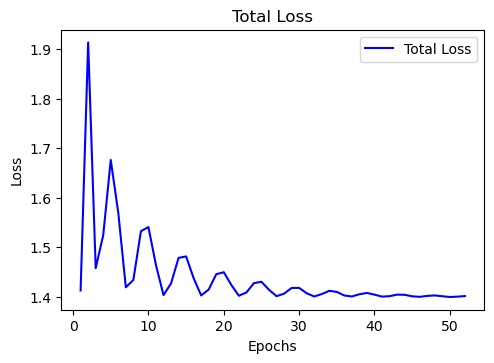

In [16]:

physics_hyperparam = [0.005]
epochs = [500]
lr_schedule = ExponentialDecay(
        initial_learning_rate=0.005,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )

y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
for epoch in epochs:
    for physics_weight in physics_hyperparam:
        print("---------- Hyperparameter combinations ------------")
        print("Epoch : {};  physics_weight: {};".format(str(epoch),  str(physics_weight)))

        m = PGGCNModel()
        m.addRule("sum", 0, 32)
        m.addRule("multiply", 32, 33)
        m.addRule("distance", 33, 36)
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        m.compile(loss=combined_loss(physics_weight), optimizer=opt)
        input_shapes = []
        for i in range(len(X_train)):
            input_shapes.append(np.array(X_train[i]).shape[0])
        m.set_input_shapes(input_shapes)
        for i in range(len(X_train)):
            if X_train[i].shape[0] < 2000:
                new_list = np.zeros([2000 - X_train[i].shape[0], 41])
                X_train[i] = np.concatenate([X_train[i], new_list], 0)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        loss_tracker = LossComponentsCallback(m)

        # Add early stopping
        early_stopping = EarlyStopping(
            monitor='loss',           
            patience=20,              
            restore_best_weights=True, 
            min_delta=0.001,          
            verbose=1                 
        )
        hist = m.fit(X_train, y_train, epochs = epoch, batch_size=len(X_train),callbacks=[early_stopping,loss_tracker])
        
        input_shapes = []
        for i in range(len(X_test)):
            input_shapes.append(np.array(X_test[i]).shape[0])
        m.set_input_shapes(input_shapes)

        for i in range(len(X_test)):
            if X_test[i].shape[0] < 2000:
                new_list = np.zeros([2000 - X_test[i].shape[0], 41])
                X_test[i] = np.concatenate([X_test[i], new_list], 0)
        X_test = np.array(X_test)
        x_c = copy.deepcopy(X_test)
        y_test = np.array(y_test)
        y_pred_test = m.predict(X_test)
        y_pred_test = np.array(y_pred_test[:,0])

        y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
        eval = m.evaluate(X_test, y_test)
        print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))

        final_train_loss = loss_tracker.total_losses[-1] if loss_tracker.total_losses else None

    # Plot all loss components over epochs
    plt.figure(figsize=(12, 8))

    epoch_length = range(1, len(loss_tracker.total_losses) + 1)

    # Total loss
    plt.subplot(2, 2, 1)
    plt.plot(epoch_length, loss_tracker.total_losses, 'b-', label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
